# Insights on Correlation Between Stock Data and Significant World Events

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import yfinance as yf
from scipy import stats

### Pulling and Cleaning the Data
There are two main data sources in this project.  The first one is from [GDELT](https://www.gdeltproject.org/).  This is our significant event data which counts the number of articles containing a certain type of disaster per day.  The second source of data is from [yfinance](https://pypi.org/project/yfinance/).  This is a python library that scrapes the yahoo finance site for stock data.

The data was pulled in from GDELT already clean.  This notebook cleanses the yahoo finance data. The yfinance data was altered with the following steps.
- Take only the closing price of each company
- Stock data is not taken on the weekends, so the weekends were forward filled to cover every day
- Times were converted to proper time zone
- Three extra entries in the stock data were remove to ensure equal array lengths with GDELT data

In [2]:
#Pull significant events data
sig_events_df = pd.read_csv('../Data/GDELT_data/article_counts_disasters.csv')
#Drop duplicate index column
sig_events_df.drop(['Unnamed: 0'], axis = 1, inplace = True)
sig_events_df['datetime'] = pd.to_datetime(sig_events_df['datetime'],utc=True)
sig_events_df.head()

,datetime,All Articles,MANMADE_DISASTER_IMPLIED,WB_2166_HEALTH_EMERGENCY_PREPAREDNESS_AND_DISASTER_RESPONSE,DISASTER_FIRE,NATURAL_DISASTER_ICE,NATURAL_DISASTER_EARTHQUAKE,NATURAL_DISASTER_FLOOD,NATURAL_DISASTER_FLOODING,NATURAL_DISASTER_HURRICANE,...,NATURAL_DISASTER_FRIGID,MANMADE_DISASTER_POWER_OUTAGE,NATURAL_DISASTER_HEATWAVE,NATURAL_DISASTER_AVALANCHES,NATURAL_DISASTER_TORRENTIAL_RAIN,SELF_IDENTIFIED_ENVIRON_DISASTER,NATURAL_DISASTER_ERUPTIONS,NATURAL_DISASTER_TWISTER,NATURAL_DISASTER_BUSHFIRE,NATURAL_DISASTER_FLASH_FLOOD
0,2017-01-01 00:00:00+00:00,427906,87559,3363,11765,4972,1956,1689,1309,459,...,384,127,22,126,132,43,55,95,65,40
1,2017-01-02 00:00:00+00:00,592774,109720,4412,11562,6742,3079,1863,1787,589,...,259,157,47,129,54,67,72,78,47,54
2,2017-01-03 00:00:00+00:00,757916,129371,5765,14952,8754,3451,3366,3629,1222,...,385,153,40,257,54,105,116,235,249,94
3,2017-01-04 00:00:00+00:00,822862,134633,6477,12470,9553,5877,4216,2672,2723,...,447,293,73,614,117,84,243,136,199,40
4,2017-01-05 00:00:00+00:00,830028,143110,6919,11297,11397,3690,5559,4315,1679,...,650,194,64,874,64,97,160,181,177,867


In [3]:
# RUN THIS ONLY IF WANTING TO CHANGE stock_prices.csv
#Pull stock data
# FOSSIL FUEL: Shell, Chevron, BP, Exxon
oil = ['SHEL','CVX','BP','XOM']
# RENEWABLE: Xcel, Tesla, STEM
renew = ['XEL','TSLA','IBDRY','JKS']

data = pd.DataFrame()
for company in oil+renew:
    c = yf.Ticker(company).history(
        period = 'max',
        interval = '1d',
        start = '2017-01-01',
        end = '2022-11-10'
    )
    #if 'Date' not in data.columns:
    #    data['Date'] = c.index
    data[company] = c['Close']
data.head()
data.to_csv("stock_prices.csv")

In [4]:
raw_stock_df = pd.read_csv("stock_prices.csv")
raw_stock_df['Date'] = pd.to_datetime(raw_stock_df['Date'],utc=True)
raw_stock_df.head()

,Date,SHEL,CVX,BP,XOM,XEL,TSLA,IBDRY,JKS
0,2017-01-03 05:00:00+00:00,40.906982,91.029160,26.699450,67.322083,34.428513,14.466000,19.981161,15.63
1,2017-01-04 05:00:00+00:00,41.321815,91.006004,26.903198,66.581383,34.581074,15.132667,19.879877,15.91
2,2017-01-05 05:00:00+00:00,41.684814,90.612061,27.099928,65.588844,34.581074,15.116667,20.107571,15.85
3,2017-01-06 05:00:00+00:00,41.329235,90.249016,26.636208,65.551811,34.682781,15.267333,19.848475,15.72
4,2017-01-09 05:00:00+00:00,40.447685,89.476616,26.214642,64.470383,34.157288,15.418667,20.060457,15.55


In [5]:
#Create combined dataframe for stock data
stock_df = pd.DataFrame(columns = ['Date'])
#Create full list of dates from start to end, with a day frequency. Timezone is so it matches timezone of stock data and
#can be merged with no issues
stock_df['Date'] = pd.date_range(start='1/1/2017', end='11/10/2022', freq = 'D', tz = 'America/New_York')
stock_df = stock_df.merge(raw_stock_df, how='outer', on='Date')
# Back fill data to fill missing data where there are weekends
stock_df.ffill(axis=0, inplace = True)
stock_df.head(10)

,Date,SHEL,CVX,BP,XOM,XEL,TSLA,IBDRY,JKS
0,2017-01-01 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-02 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-03 00:00:00-05:00,40.906982,91.029160,26.699450,67.322083,34.428513,14.466000,19.981161,15.63
3,2017-01-04 00:00:00-05:00,41.321815,91.006004,26.903198,66.581383,34.581074,15.132667,19.879877,15.91
4,2017-01-05 00:00:00-05:00,41.684814,90.612061,27.099928,65.588844,34.581074,15.116667,20.107571,15.85
5,2017-01-06 00:00:00-05:00,41.329235,90.249016,26.636208,65.551811,34.682781,15.267333,19.848475,15.72
6,2017-01-07 00:00:00-05:00,41.329235,90.249016,26.636208,65.551811,34.682781,15.267333,19.848475,15.72
7,2017-01-08 00:00:00-05:00,41.329235,90.249016,26.636208,65.551811,34.682781,15.267333,19.848475,15.72
8,2017-01-09 00:00:00-05:00,40.447685,89.476616,26.214642,64.470383,34.157288,15.418667,20.060457,15.55
9,2017-01-10 00:00:00-05:00,40.277298,88.796883,26.074120,63.648220,34.148811,15.324667,19.817064,15.65


In [6]:
corr_pearson_df = pd.DataFrame(sig_events_df.columns[1:],columns = ['GDELT_theme'])
for col in stock_df.columns[1:]:
    corr_pearson_df[col] = sig_events_df.corrwith(stock_df[col]).values
corr_pearson_df.set_index('GDELT_theme', inplace = True)

corr_pearson_df.head()

,SHEL,CVX,BP,XOM,XEL,TSLA,IBDRY,JKS
GDELT_theme,,,,,,,,
All Articles,0.147654,-0.330461,0.225351,-0.047808,-0.723220,-0.615255,-0.684069,-0.599788
MANMADE_DISASTER_IMPLIED,0.193023,-0.338757,0.274029,-0.025047,-0.786929,-0.688499,-0.756678,-0.658383
WB_2166_HEALTH_EMERGENCY_PREPAREDNESS_AND_DISASTER_RESPONSE,-0.696289,-0.264561,-0.679025,-0.532550,0.460685,0.320874,0.561989,0.224367
DISASTER_FIRE,0.269574,-0.209043,0.334232,0.058315,-0.629724,-0.584766,-0.632934,-0.550532
NATURAL_DISASTER_ICE,0.217866,-0.254829,0.262791,-0.001297,-0.667559,-0.516784,-0.609375,-0.480726


Text(0.02, 0.5, 'Pearson Correlation Coefficient')

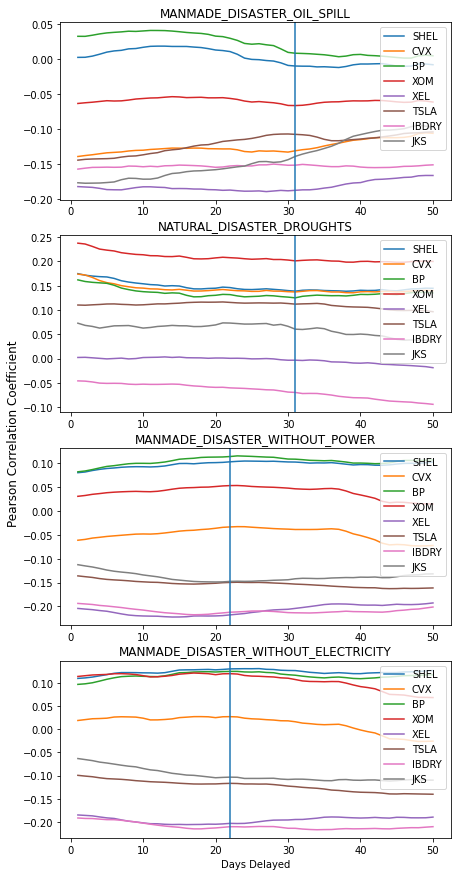

In [19]:
fig,ax = plt.subplots(4,1,figsize=(7,15))
num_days = 50
days_delayed_data = np.zeros([8,num_days])
X = range(1,num_days+1)
event = "MANMADE_DISASTER_OIL_SPILL"
for delay in X:
    sig_y = sig_events_df[event][:-delay]
    for i,cp in enumerate(stock_df.columns[1:]):
        stock_y = stock_df[cp][3+delay:]
        days_delayed_data[i,delay-1] = stats.pearsonr(stock_y,sig_y)[0]
for i,cp in enumerate(stock_df.columns[1:]):
    ax[0].plot(X,days_delayed_data[i],label = cp)
ax[0].set_title(event)
ax[0].axvline(31)

days_delayed_data = np.zeros([8,num_days])
event = "NATURAL_DISASTER_DROUGHTS"
for delay in X:
    sig_y = sig_events_df[event][:-delay]
    for i,cp in enumerate(stock_df.columns[1:]):
        stock_y = stock_df[cp][3+delay:]
        days_delayed_data[i,delay-1] = stats.pearsonr(stock_y,sig_y)[0]
for i,cp in enumerate(stock_df.columns[1:]):
    ax[1].plot(X,days_delayed_data[i],label = cp)
ax[1].set_title(event)
ax[1].axvline(31)

days_delayed_data = np.zeros([8,num_days])
event = "MANMADE_DISASTER_WITHOUT_POWER"
for delay in X:
    sig_y = sig_events_df[event][:-delay]
    for i,cp in enumerate(stock_df.columns[1:]):
        stock_y = stock_df[cp][3+delay:]
        days_delayed_data[i,delay-1] = stats.pearsonr(stock_y,sig_y)[0]
for i,cp in enumerate(stock_df.columns[1:]):
    ax[2].plot(X,days_delayed_data[i],label = cp)
ax[2].set_title(event)
ax[2].axvline(22)

days_delayed_data = np.zeros([8,num_days])
event = "MANMADE_DISASTER_WITHOUT_ELECTRICITY"
for delay in X:
    sig_y = sig_events_df[event][:-delay]
    for i,cp in enumerate(stock_df.columns[1:]):
        stock_y = stock_df[cp][3+delay:]
        days_delayed_data[i,delay-1] = stats.pearsonr(stock_y,sig_y)[0]
for i,cp in enumerate(stock_df.columns[1:]):
    ax[3].plot(X,days_delayed_data[i],label = cp)
ax[3].set_title(event)
ax[3].axvline(22)

for i in range(4):
    ax[i].legend(loc='upper right')
plt.xlabel("Days Delayed")
fig.supylabel("Pearson Correlation Coefficient")

In [20]:
sig_events_df.columns

Index(['datetime', 'All Articles', 'MANMADE_DISASTER_IMPLIED',
       'WB_2166_HEALTH_EMERGENCY_PREPAREDNESS_AND_DISASTER_RESPONSE',
       'DISASTER_FIRE', 'NATURAL_DISASTER_ICE', 'NATURAL_DISASTER_EARTHQUAKE',
       'NATURAL_DISASTER_FLOOD', 'NATURAL_DISASTER_FLOODING',
       'NATURAL_DISASTER_HURRICANE', 'NATURAL_DISASTER_FLOODS',
       'NATURAL_DISASTER_FLOODED', 'NATURAL_DISASTER_DROUGHT',
       'NATURAL_DISASTER_HEAVY_RAIN', 'NATURAL_DISASTER_DROWNED',
       'NATURAL_DISASTER_EARTHQUAKES', 'NATURAL_DISASTER_EROSION',
       'NATURAL_DISASTER_WILDFIRE', 'MANMADE_DISASTER_TRAFFIC_ACCIDENT',
       'NATURAL_DISASTER_TSUNAMI', 'NATURAL_DISASTER_DROWNING',
       'NATURAL_DISASTER_NATURAL_DISASTERS', 'NATURAL_DISASTER_STRONG_WINDS',
       'NATURAL_DISASTER_LANDSLIDES', 'NATURAL_DISASTER_WILDFIRES',
       'MANMADE_DISASTER_ROAD_ACCIDENT', 'NATURAL_DISASTER_AVALANCHE',
       'NATURAL_DISASTER_VOLCANO', 'NATURAL_DISASTER_HURRICANES',
       'NATURAL_DISASTER_CYCLONE', 'NATURAL_DI

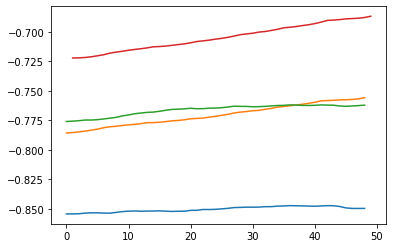

In [21]:
corr_per_days_delayed = []
MANMADE_DISASTER_ROAD_ACCIDENT = []
MANMADE_DISASTER_IMPLIED = []
MANMADE_DISASTER_TRAFFIC_ACCIDENT = []
All_Articles = []
X = range(1,50)
for delay in X:
    stock_y = stock_df.XEL[3+delay:]
    sig_y = sig_events_df.MANMADE_DISASTER_ROAD_ACCIDENT[:-delay]
    MANMADE_DISASTER_ROAD_ACCIDENT.append(stats.pearsonr(stock_y,sig_y)[0])
    sig_y = sig_events_df.MANMADE_DISASTER_IMPLIED[:-delay]
    MANMADE_DISASTER_IMPLIED.append(stats.pearsonr(stock_y,sig_y)[0])
    sig_y = sig_events_df.MANMADE_DISASTER_TRAFFIC_ACCIDENT[:-delay]
    MANMADE_DISASTER_TRAFFIC_ACCIDENT.append(stats.pearsonr(stock_y,sig_y)[0])
    sig_y = sig_events_df["All Articles"][:-delay]
    All_Articles.append(stats.pearsonr(stock_y,sig_y)[0])
plt.plot(MANMADE_DISASTER_ROAD_ACCIDENT)
plt.plot(MANMADE_DISASTER_IMPLIED)
plt.plot(MANMADE_DISASTER_TRAFFIC_ACCIDENT)
plt.plot(X,All_Articles)

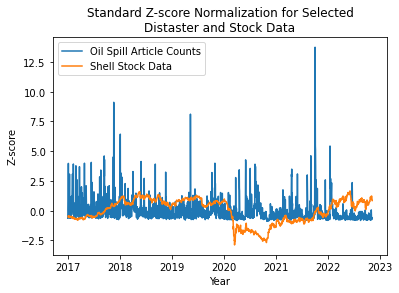

In [22]:
sig_y = sig_events_df.MANMADE_DISASTER_OIL_SPILL
sig_y -= np.mean(sig_y)
sig_y /= np.std(sig_y)
plt.plot(sig_events_df.datetime,sig_y,label='Oil Spill Article Counts')

stock_y = stock_df.SHEL
stock_y -= np.mean(stock_y)
stock_y /= np.std(stock_y)
plt.plot(stock_df.Date,stock_df.SHEL,label='Shell Stock Data')
plt.title("Standard Z-score Normalization for Selected\nDistaster and Stock Data")
plt.ylabel("Z-score")
plt.xlabel("Year")
plt.legend();

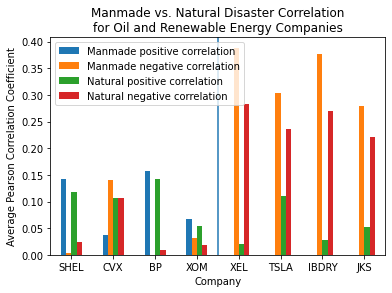

<Figure size 7200x4800 with 0 Axes>

In [32]:
MANMADE = corr_pearson_df.index.str.contains('MANMADE')
NATURAL = corr_pearson_df.index.str.contains('NATURAL')
num_cps = len(corr_pearson_df.columns)
vals = np.zeros([4,num_cps])
for i in range(num_cps):
    cp = corr_pearson_df.columns[i]
    vals[0,i] = corr_pearson_df[MANMADE&(corr_pearson_df[cp]>0)][cp].mean()
    vals[1,i] = -corr_pearson_df[MANMADE&(corr_pearson_df[cp]<0)][cp].mean()
    vals[2,i] = corr_pearson_df[NATURAL&(corr_pearson_df[cp]>0)][cp].mean()
    vals[3,i] = -corr_pearson_df[NATURAL&(corr_pearson_df[cp]<0)][cp].mean()
vals[np.isnan(vals)] = 0

corr_type_df = pd.DataFrame(vals.T,columns = ['Manmade positive correlation',
                                              'Manmade negative correlation',
                                              'Natural positive correlation',
                                              'Natural negative correlation'])
corr_type_df['Company'] = corr_pearson_df.columns
corr_type_df.set_index('Company', inplace = True)
corr_type_df.head(10)

corr_type_df.plot.bar(rot=0)
plt.axvline(x=3.5)
plt.ylabel("Average Pearson Correlation Coefficient")
plt.title("Manmade vs. Natural Disaster Correlation\nfor Oil and Renewable Energy Companies")
plt.figure(dpi=1200)

In [45]:
for cp in corr_pearson_df.columns[:4]:
    print()
    print(cp,':',corr_pearson_df[cp].nlargest(5))


SHEL : GDELT_theme
MANMADE_DISASTER_ROAD_ACCIDENT    0.295317
DISASTER_FIRE                     0.269574
NATURAL_DISASTER_DROUGHT          0.244546
NATURAL_DISASTER_DROWN            0.226630
MANMADE_DISASTER_CAR_ACCIDENT     0.222706
Name: SHEL, dtype: float64

CVX : GDELT_theme
NATURAL_DISASTER_DROUGHTS           0.177334
NATURAL_DISASTER_EXTREME_WEATHER    0.128888
NATURAL_DISASTER_DROUGHT            0.123055
NATURAL_DISASTER_HEATWAVE           0.119545
NATURAL_DISASTER_HEAT_WAVE          0.093427
Name: CVX, dtype: float64

BP : GDELT_theme
MANMADE_DISASTER_ROAD_ACCIDENT    0.340741
DISASTER_FIRE                     0.334232
NATURAL_DISASTER_DROWN            0.281246
MANMADE_DISASTER_IMPLIED          0.274029
MANMADE_DISASTER_CAR_ACCIDENT     0.273006
Name: BP, dtype: float64

XOM : GDELT_theme
NATURAL_DISASTER_DROUGHT            0.292392
NATURAL_DISASTER_DROUGHTS           0.239657
MANMADE_DISASTER_RADIOACTIVE        0.168783
NATURAL_DISASTER_EXTREME_WEATHER    0.165675
NATURAL_DIS

In [46]:
for cp in corr_pearson_df.columns[4:]:
    print()
    print(cp,':',corr_pearson_df[cp].nsmallest(5))


XEL : GDELT_theme
MANMADE_DISASTER_ROAD_ACCIDENT      -0.853846
MANMADE_DISASTER_IMPLIED            -0.786929
MANMADE_DISASTER_TRAFFIC_ACCIDENT   -0.775895
All Articles                        -0.723220
NATURAL_DISASTER_ICE                -0.667559
Name: XEL, dtype: float64

TSLA : GDELT_theme
MANMADE_DISASTER_IMPLIED            -0.688499
MANMADE_DISASTER_ROAD_ACCIDENT      -0.667541
All Articles                        -0.615255
MANMADE_DISASTER_TRAFFIC_ACCIDENT   -0.598465
DISASTER_FIRE                       -0.584766
Name: TSLA, dtype: float64

IBDRY : GDELT_theme
MANMADE_DISASTER_ROAD_ACCIDENT      -0.831804
MANMADE_DISASTER_IMPLIED            -0.756678
MANMADE_DISASTER_TRAFFIC_ACCIDENT   -0.750965
All Articles                        -0.684069
DISASTER_FIRE                       -0.632934
Name: IBDRY, dtype: float64

JKS : GDELT_theme
MANMADE_DISASTER_IMPLIED            -0.658383
All Articles                        -0.599788
MANMADE_DISASTER_ROAD_ACCIDENT      -0.578563
DISASTER_FIR

In [25]:
shift = 26
corr_pearson_df_shifted = pd.DataFrame(sig_events_df.columns[1:],columns = ['GDELT_theme'])
for col in stock_df.columns[1:]:
    corr_pearson_df_shifted[col] = sig_events_df[:-shift].corrwith(stock_df[col][3+shift:]).values
corr_pearson_df_shifted.set_index('GDELT_theme', inplace = True)

corr_pearson_df_shifted.head()

,SHEL,CVX,BP,XOM,XEL,TSLA,IBDRY,JKS
GDELT_theme,,,,,,,,
All Articles,0.179452,-0.308582,0.253408,-0.015837,-0.714775,-0.611924,-0.677466,-0.595198
MANMADE_DISASTER_IMPLIED,0.227635,-0.313006,0.304665,0.013887,-0.780611,-0.686573,-0.752904,-0.654542
WB_2166_HEALTH_EMERGENCY_PREPAREDNESS_AND_DISASTER_RESPONSE,-0.703660,-0.272126,-0.683647,-0.552415,0.461436,0.322231,0.562249,0.224199
DISASTER_FIRE,0.298547,-0.175666,0.359088,0.102511,-0.619163,-0.577255,-0.626049,-0.541716
NATURAL_DISASTER_ICE,0.275491,-0.230080,0.313301,0.029412,-0.658735,-0.521418,-0.600599,-0.480467


In [26]:
for cp in corr_pearson_df.columns[4:]:
    print()
    print(cp,':',corr_pearson_df_shifted[cp].nsmallest(5))


XEL : GDELT_theme
MANMADE_DISASTER_ROAD_ACCIDENT      -0.848972
MANMADE_DISASTER_IMPLIED            -0.780611
MANMADE_DISASTER_TRAFFIC_ACCIDENT   -0.768339
All Articles                        -0.714775
NATURAL_DISASTER_ICE                -0.658735
Name: XEL, dtype: float64

TSLA : GDELT_theme
MANMADE_DISASTER_IMPLIED            -0.686573
MANMADE_DISASTER_ROAD_ACCIDENT      -0.663855
All Articles                        -0.611924
MANMADE_DISASTER_TRAFFIC_ACCIDENT   -0.592504
DISASTER_FIRE                       -0.577255
Name: TSLA, dtype: float64

IBDRY : GDELT_theme
MANMADE_DISASTER_ROAD_ACCIDENT      -0.828236
MANMADE_DISASTER_IMPLIED            -0.752904
MANMADE_DISASTER_TRAFFIC_ACCIDENT   -0.744984
All Articles                        -0.677466
DISASTER_FIRE                       -0.626049
Name: IBDRY, dtype: float64

JKS : GDELT_theme
MANMADE_DISASTER_IMPLIED            -0.654542
All Articles                        -0.595198
MANMADE_DISASTER_ROAD_ACCIDENT      -0.570910
DISASTER_FIR